# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
# ! pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

In [2]:
# ! pip install -r https://raw.githubusercontent.com/Lasagne/Lasagne/v0.1/requirements.txt

In [3]:
# ! pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

In [4]:
# ! pip install Lasagne==0.1

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS='floatX=float32'

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


### Experiment setup
* Here we simply load the game and check that it works

In [6]:
import gym
make_env = lambda: gym.make("LunarLander-v2")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-11-04 21:43:28,744] Making new env: LunarLander-v2


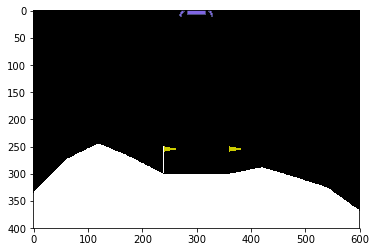

In [7]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [8]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import rectify


#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,)+state_shape)


nn = DenseLayer(observation_layer, 200, nonlinearity=rectify)
nn = DenseLayer(nn, 200, nonlinearity=rectify)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(nn,num_units=n_actions,
                           nonlinearity=None,name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [9]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [10]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)

In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [12]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-11-04 21:43:45,987] Making new env: LunarLander-v2


In [13]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)

print('actions:',action_log)
print('rewards:',reward_log)

actions: [[3 3 3 3 0]]
rewards: [[-2.19124697 -2.53940291 -2.71452379 -2.93581575  0.        ]]
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 102 ms


In [14]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH)

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [15]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [16]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [17]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [18]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-11-04 21:44:06,339] Making new env: LunarLander-v2
[2017-11-04 21:44:06,345] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:44:06,488] Starting new video recorder writing to /home/nimloth/coding/7sem/machine_learning_7sem/hw5/records/openaigym.video.0.3688.video000000.mp4
[2017-11-04 21:44:09,235] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')


Episode finished after 76 timesteps with reward=-617.390574482624


In [19]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [20]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards
target_score = 0

In [21]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 98/10000 [00:06<10:07, 16.30it/s][2017-11-04 21:44:16,606] Making new env: LunarLander-v2
[2017-11-04 21:44:16,617] Clearing 4 monitor files from previous run (because force=True was provided)


Episode finished after 96 timesteps with reward=-175.8561231188205
Episode finished after 75 timesteps with reward=-117.21432035374063
Episode finished after 89 timesteps with reward=-322.612053233502


[2017-11-04 21:44:16,944] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  1%|          | 102/10000 [00:06<10:43, 15.37it/s]

iter=100	epsilon=0.910
Current score(mean over 3) = -205.227


  2%|▏         | 199/10000 [00:12<09:51, 16.57it/s][2017-11-04 21:44:22,497] Making new env: LunarLander-v2
[2017-11-04 21:44:22,501] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:44:22,706] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  2%|▏         | 201/10000 [00:12<10:01, 16.30it/s]

Episode finished after 93 timesteps with reward=-74.76010765098812
Episode finished after 74 timesteps with reward=-193.68500793752838
Episode finished after 96 timesteps with reward=-354.87239511823486
iter=200	epsilon=0.828
Current score(mean over 3) = -207.773


  3%|▎         | 299/10000 [00:18<10:14, 15.80it/s][2017-11-04 21:44:29,413] Making new env: LunarLander-v2
[2017-11-04 21:44:29,417] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:44:29,759] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')


Episode finished after 214 timesteps with reward=-181.16191874785338
Episode finished after 96 timesteps with reward=-352.26739986826044
Episode finished after 104 timesteps with reward=-279.2825033289703
iter=300	epsilon=0.754
Current score(mean over 3) = -270.904


  4%|▍         | 399/10000 [00:24<09:51, 16.22it/s][2017-11-04 21:44:35,093] Making new env: LunarLander-v2
[2017-11-04 21:44:35,097] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:44:35,375] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  4%|▍         | 401/10000 [00:25<09:58, 16.04it/s]

Episode finished after 145 timesteps with reward=-247.2003151186183
Episode finished after 110 timesteps with reward=-213.98854903434164
Episode finished after 103 timesteps with reward=-107.95190767523809
iter=400	epsilon=0.687
Current score(mean over 3) = -189.714


  5%|▍         | 499/10000 [00:31<09:51, 16.06it/s][2017-11-04 21:44:41,575] Making new env: LunarLander-v2
[2017-11-04 21:44:41,581] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:44:41,968] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')


Episode finished after 147 timesteps with reward=-218.48269189539647
Episode finished after 85 timesteps with reward=-238.2447884938585
Episode finished after 121 timesteps with reward=-184.15607754230263
iter=500	epsilon=0.626
Current score(mean over 3) = -213.628


  6%|▌         | 598/10000 [00:39<10:21, 15.13it/s][2017-11-04 21:44:50,138] Making new env: LunarLander-v2
[2017-11-04 21:44:50,143] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 133 timesteps with reward=-219.4805282109657
Episode finished after 154 timesteps with reward=-130.1275150612402
Episode finished after 127 timesteps with reward=-142.01955772406887


[2017-11-04 21:44:50,483] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  6%|▌         | 602/10000 [00:40<10:27, 14.99it/s]

iter=600	epsilon=0.571
Current score(mean over 3) = -163.876


  7%|▋         | 698/10000 [00:47<10:33, 14.69it/s][2017-11-04 21:44:58,082] Making new env: LunarLander-v2
[2017-11-04 21:44:58,085] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 113 timesteps with reward=-272.3665539634467
Episode finished after 124 timesteps with reward=-237.90117881383
Episode finished after 144 timesteps with reward=-228.28430370814092


[2017-11-04 21:44:58,416] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  7%|▋         | 702/10000 [00:48<10:37, 14.58it/s]

iter=700	epsilon=0.522
Current score(mean over 3) = -246.184


  8%|▊         | 799/10000 [00:56<10:49, 14.17it/s][2017-11-04 21:45:06,930] Making new env: LunarLander-v2
[2017-11-04 21:45:06,934] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 340 timesteps with reward=-298.73973157892243
Episode finished after 206 timesteps with reward=-465.9060590734472


[2017-11-04 21:45:07,838] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  8%|▊         | 801/10000 [00:57<11:00, 13.92it/s]

Episode finished after 152 timesteps with reward=-233.44349570192864
iter=800	epsilon=0.477
Current score(mean over 3) = -332.696


  9%|▉         | 898/10000 [01:08<11:30, 13.17it/s][2017-11-04 21:45:18,719] Making new env: LunarLander-v2
[2017-11-04 21:45:18,723] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 221 timesteps with reward=-283.5669916401151
Episode finished after 342 timesteps with reward=-414.4710872798364
Episode finished after 127 timesteps with reward=-77.16770995868976


[2017-11-04 21:45:19,453] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  9%|▉         | 902/10000 [01:09<11:37, 13.04it/s]

iter=900	epsilon=0.436
Current score(mean over 3) = -258.402


 10%|▉         | 998/10000 [01:18<11:46, 12.74it/s][2017-11-04 21:45:28,923] Making new env: LunarLander-v2
[2017-11-04 21:45:28,927] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 225 timesteps with reward=-291.2325435903788
Episode finished after 406 timesteps with reward=-527.1861079558438
Episode finished after 369 timesteps with reward=-139.78431966764714


[2017-11-04 21:45:30,136] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 10%|█         | 1002/10000 [01:19<11:57, 12.55it/s]

iter=1000	epsilon=0.399
Current score(mean over 3) = -319.401


 11%|█         | 1099/10000 [01:30<12:10, 12.19it/s][2017-11-04 21:45:40,652] Making new env: LunarLander-v2
[2017-11-04 21:45:40,656] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 213 timesteps with reward=-209.71826234487713
Episode finished after 402 timesteps with reward=-300.1090374152269
Episode finished after 148 timesteps with reward=-206.49433570408974


[2017-11-04 21:45:41,401] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 11%|█         | 1101/10000 [01:31<12:16, 12.09it/s]

iter=1100	epsilon=0.366
Current score(mean over 3) = -238.774


 12%|█▏        | 1199/10000 [01:40<12:18, 11.92it/s][2017-11-04 21:45:51,137] Making new env: LunarLander-v2
[2017-11-04 21:45:51,141] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 423 timesteps with reward=-218.83044621427933
Episode finished after 1000 timesteps with reward=-57.571140522216425
Episode finished after 438 timesteps with reward=-298.74798433196065


[2017-11-04 21:45:54,595] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 12%|█▏        | 1201/10000 [01:44<12:44, 11.51it/s]

iter=1200	epsilon=0.336
Current score(mean over 3) = -191.717


 13%|█▎        | 1299/10000 [01:59<13:19, 10.88it/s][2017-11-04 21:46:09,992] Making new env: LunarLander-v2
[2017-11-04 21:46:09,996] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:46:10,695] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 13%|█▎        | 1301/10000 [02:00<13:25, 10.81it/s]

Episode finished after 179 timesteps with reward=-297.1729653367444
Episode finished after 295 timesteps with reward=-350.47405792308405
Episode finished after 142 timesteps with reward=-104.82398941323528
iter=1300	epsilon=0.309
Current score(mean over 3) = -250.824


 14%|█▍        | 1398/10000 [02:10<13:20, 10.75it/s][2017-11-04 21:46:20,652] Making new env: LunarLander-v2
[2017-11-04 21:46:20,657] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 505 timesteps with reward=-162.46510855164718
Episode finished after 1000 timesteps with reward=-164.9939190978329


[2017-11-04 21:46:27,271] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 14%|█▍        | 1401/10000 [02:16<14:00, 10.23it/s]

Episode finished after 1000 timesteps with reward=-117.5601886346043
iter=1400	epsilon=0.284
Current score(mean over 3) = -148.340


 15%|█▍        | 1499/10000 [02:27<13:53, 10.19it/s][2017-11-04 21:46:37,569] Making new env: LunarLander-v2
[2017-11-04 21:46:37,573] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 135 timesteps with reward=-255.05165580622128
Episode finished after 426 timesteps with reward=-345.4737497564911
Episode finished after 245 timesteps with reward=-224.79546391465118


[2017-11-04 21:46:38,602] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 15%|█▌        | 1501/10000 [02:28<13:59, 10.13it/s]

iter=1500	epsilon=0.262
Current score(mean over 3) = -275.107


 16%|█▌        | 1598/10000 [02:38<13:55, 10.06it/s][2017-11-04 21:46:49,441] Making new env: LunarLander-v2
[2017-11-04 21:46:49,446] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 359 timesteps with reward=-169.1535908752931


[2017-11-04 21:46:53,829] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 16%|█▌        | 1601/10000 [02:43<14:17,  9.79it/s]

Episode finished after 859 timesteps with reward=117.02462914778152
Episode finished after 465 timesteps with reward=-175.983938641693
iter=1600	epsilon=0.242
Current score(mean over 3) = -76.038


 17%|█▋        | 1698/10000 [02:56<14:22,  9.62it/s][2017-11-04 21:47:07,096] Making new env: LunarLander-v2
[2017-11-04 21:47:07,101] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 255 timesteps with reward=-62.088849316712086
Episode finished after 220 timesteps with reward=-212.19411406208576


[2017-11-04 21:47:08,848] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 17%|█▋        | 1701/10000 [02:58<14:31,  9.53it/s]

Episode finished after 672 timesteps with reward=-354.2608501185065
iter=1700	epsilon=0.224
Current score(mean over 3) = -209.515


 18%|█▊        | 1798/10000 [03:10<14:27,  9.46it/s][2017-11-04 21:47:20,815] Making new env: LunarLander-v2
[2017-11-04 21:47:20,819] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:47:24,706] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 18%|█▊        | 1801/10000 [03:14<14:45,  9.26it/s]

Episode finished after 1000 timesteps with reward=-96.37195319244412
Episode finished after 440 timesteps with reward=-150.73291358657985
Episode finished after 163 timesteps with reward=-129.30550214642324
iter=1800	epsilon=0.207
Current score(mean over 3) = -125.470


 19%|█▉        | 1899/10000 [03:28<14:51,  9.09it/s][2017-11-04 21:47:39,579] Making new env: LunarLander-v2
[2017-11-04 21:47:39,583] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 375 timesteps with reward=-123.06932376026136
Episode finished after 1000 timesteps with reward=-216.51694509413625


[2017-11-04 21:47:43,079] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 19%|█▉        | 1900/10000 [03:32<15:06,  8.93it/s]

Episode finished after 189 timesteps with reward=-160.14692250897437
iter=1900	epsilon=0.192
Current score(mean over 3) = -166.578


 20%|█▉        | 1999/10000 [03:44<14:57,  8.92it/s][2017-11-04 21:47:54,734] Making new env: LunarLander-v2
[2017-11-04 21:47:54,738] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 294 timesteps with reward=-78.32867679947047
Episode finished after 1000 timesteps with reward=-145.72099192974167
Episode finished after 279 timesteps with reward=-183.56907187253194


[2017-11-04 21:47:57,216] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 20%|██        | 2001/10000 [03:46<15:07,  8.82it/s]

iter=2000	epsilon=0.179
Current score(mean over 3) = -135.873


 21%|██        | 2099/10000 [04:03<15:17,  8.61it/s][2017-11-04 21:48:14,474] Making new env: LunarLander-v2
[2017-11-04 21:48:14,478] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-179.49182176225062


[2017-11-04 21:48:19,662] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 21%|██        | 2100/10000 [04:09<15:37,  8.43it/s]

Episode finished after 1000 timesteps with reward=-108.15416068032542
Episode finished after 245 timesteps with reward=-258.27197449541745
iter=2100	epsilon=0.166
Current score(mean over 3) = -181.973


 22%|██▏       | 2199/10000 [04:24<15:38,  8.31it/s][2017-11-04 21:48:35,212] Making new env: LunarLander-v2
[2017-11-04 21:48:35,216] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 759 timesteps with reward=110.2457204000158


[2017-11-04 21:48:39,598] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 22%|██▏       | 2201/10000 [04:29<15:54,  8.17it/s]

Episode finished after 1000 timesteps with reward=-150.76960928521876
Episode finished after 175 timesteps with reward=-136.85704447196775
iter=2200	epsilon=0.155
Current score(mean over 3) = -59.127


 23%|██▎       | 2299/10000 [04:44<15:53,  8.08it/s][2017-11-04 21:48:55,122] Making new env: LunarLander-v2
[2017-11-04 21:48:55,126] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-154.65235668664855


[2017-11-04 21:48:58,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 23%|██▎       | 2301/10000 [04:48<16:05,  7.98it/s]

Episode finished after 292 timesteps with reward=-257.4752986649988
Episode finished after 308 timesteps with reward=-301.8522049813717
iter=2300	epsilon=0.145
Current score(mean over 3) = -237.993


 24%|██▍       | 2399/10000 [05:08<16:17,  7.77it/s][2017-11-04 21:49:19,134] Making new env: LunarLander-v2
[2017-11-04 21:49:19,139] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-149.62567897049442
Episode finished after 190 timesteps with reward=-89.59505422179646


[2017-11-04 21:49:21,934] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 24%|██▍       | 2401/10000 [05:11<16:26,  7.70it/s]

Episode finished after 144 timesteps with reward=-182.89929966908852
iter=2400	epsilon=0.136
Current score(mean over 3) = -140.707


 25%|██▍       | 2499/10000 [05:28<16:25,  7.61it/s][2017-11-04 21:49:38,956] Making new env: LunarLander-v2
[2017-11-04 21:49:38,962] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.42775156950262


[2017-11-04 21:49:45,059] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 25%|██▌       | 2500/10000 [05:34<16:43,  7.47it/s]

Episode finished after 406 timesteps with reward=-147.95018360746838
Episode finished after 173 timesteps with reward=-64.73322615491634
iter=2500	epsilon=0.128
Current score(mean over 3) = -115.037


 26%|██▌       | 2599/10000 [05:50<16:38,  7.41it/s][2017-11-04 21:50:01,176] Making new env: LunarLander-v2
[2017-11-04 21:50:01,180] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.89706752944016
Episode finished after 1000 timesteps with reward=-116.54195767255422


[2017-11-04 21:50:10,979] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 26%|██▌       | 2600/10000 [06:00<17:06,  7.21it/s]

Episode finished after 1000 timesteps with reward=-128.36819445270103
iter=2600	epsilon=0.121
Current score(mean over 3) = -125.936


 27%|██▋       | 2699/10000 [06:19<17:05,  7.12it/s][2017-11-04 21:50:29,732] Making new env: LunarLander-v2
[2017-11-04 21:50:29,736] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-97.49870514199944
Episode finished after 245 timesteps with reward=-323.7940588670819


[2017-11-04 21:50:34,126] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 27%|██▋       | 2700/10000 [06:23<17:17,  7.04it/s]

Episode finished after 1000 timesteps with reward=-144.7355564338846
iter=2700	epsilon=0.114
Current score(mean over 3) = -188.676


 28%|██▊       | 2799/10000 [06:41<17:12,  6.97it/s][2017-11-04 21:50:51,890] Making new env: LunarLander-v2
[2017-11-04 21:50:51,894] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:50:52,915] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 28%|██▊       | 2801/10000 [06:42<17:14,  6.96it/s]

Episode finished after 341 timesteps with reward=-291.6913366808876
Episode finished after 303 timesteps with reward=-241.2551150147586
Episode finished after 245 timesteps with reward=-293.5933671192848
iter=2800	epsilon=0.108
Current score(mean over 3) = -275.513


 29%|██▉       | 2899/10000 [06:57<17:02,  6.94it/s][2017-11-04 21:51:08,028] Making new env: LunarLander-v2
[2017-11-04 21:51:08,033] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:51:10,743] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 29%|██▉       | 2900/10000 [07:00<17:09,  6.90it/s]

Episode finished after 1000 timesteps with reward=-146.7229966988015
Episode finished after 236 timesteps with reward=-257.44424387480893
Episode finished after 220 timesteps with reward=-163.4074884760995
iter=2900	epsilon=0.102
Current score(mean over 3) = -189.192


 30%|██▉       | 2999/10000 [07:17<17:00,  6.86it/s][2017-11-04 21:51:27,725] Making new env: LunarLander-v2
[2017-11-04 21:51:27,729] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 348 timesteps with reward=-321.47387815718173


[2017-11-04 21:51:33,565] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 30%|███       | 3000/10000 [07:23<17:13,  6.77it/s]

Episode finished after 1000 timesteps with reward=-146.78283051513367
Episode finished after 1000 timesteps with reward=-124.71625986479583
iter=3000	epsilon=0.097
Current score(mean over 3) = -197.658


 31%|███       | 3099/10000 [07:42<17:09,  6.70it/s][2017-11-04 21:51:52,997] Making new env: LunarLander-v2
[2017-11-04 21:51:53,001] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-128.97840311006286
Episode finished after 1000 timesteps with reward=-134.30125536734434


[2017-11-04 21:51:59,082] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 31%|███       | 3102/10000 [07:48<17:22,  6.62it/s]

Episode finished after 470 timesteps with reward=-288.2526592074047
iter=3100	epsilon=0.093
Current score(mean over 3) = -183.844


 32%|███▏      | 3199/10000 [08:05<17:11,  6.59it/s][2017-11-04 21:52:15,911] Making new env: LunarLander-v2
[2017-11-04 21:52:15,916] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-177.50179587058358
Episode finished after 1000 timesteps with reward=-188.10766346339238


[2017-11-04 21:52:26,438] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 32%|███▏      | 3200/10000 [08:16<17:34,  6.45it/s]

Episode finished after 1000 timesteps with reward=-128.3653357617649
iter=3200	epsilon=0.089
Current score(mean over 3) = -164.658


 33%|███▎      | 3299/10000 [08:36<17:29,  6.38it/s][2017-11-04 21:52:47,470] Making new env: LunarLander-v2
[2017-11-04 21:52:47,474] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 424 timesteps with reward=-193.61349263756728
Episode finished after 391 timesteps with reward=-301.2182738814723


[2017-11-04 21:52:51,499] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 33%|███▎      | 3301/10000 [08:41<17:37,  6.33it/s]

Episode finished after 1000 timesteps with reward=-166.61953995640178
iter=3300	epsilon=0.085
Current score(mean over 3) = -220.484


 34%|███▍      | 3399/10000 [08:56<17:22,  6.33it/s][2017-11-04 21:53:07,524] Making new env: LunarLander-v2
[2017-11-04 21:53:07,528] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 93 timesteps with reward=-532.428294554547
Episode finished after 1000 timesteps with reward=-160.04764027140985
Episode finished after 433 timesteps with reward=-155.41093905806747


[2017-11-04 21:53:10,776] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 34%|███▍      | 3401/10000 [09:00<17:28,  6.29it/s]

iter=3400	epsilon=0.082
Current score(mean over 3) = -282.629


 35%|███▍      | 3498/10000 [09:14<17:11,  6.31it/s][2017-11-04 21:53:25,293] Making new env: LunarLander-v2
[2017-11-04 21:53:25,297] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 96 timesteps with reward=-303.73488491046606
Episode finished after 1000 timesteps with reward=-138.4373765576737


[2017-11-04 21:53:30,503] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 35%|███▌      | 3501/10000 [09:20<17:19,  6.25it/s]

Episode finished after 1000 timesteps with reward=-126.33596033919608
iter=3500	epsilon=0.079
Current score(mean over 3) = -189.503


 36%|███▌      | 3599/10000 [09:32<16:58,  6.28it/s][2017-11-04 21:53:43,492] Making new env: LunarLander-v2
[2017-11-04 21:53:43,496] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:53:47,679] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 36%|███▌      | 3601/10000 [09:37<17:06,  6.24it/s]

Episode finished after 1000 timesteps with reward=-138.7492856009859
Episode finished after 1000 timesteps with reward=-157.14819941925626
Episode finished after 86 timesteps with reward=-377.7682241809369
iter=3600	epsilon=0.076
Current score(mean over 3) = -224.555


 37%|███▋      | 3699/10000 [09:53<16:51,  6.23it/s][2017-11-04 21:54:04,052] Making new env: LunarLander-v2
[2017-11-04 21:54:04,056] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-80.1781062964584


[2017-11-04 21:54:11,022] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 37%|███▋      | 3702/10000 [10:00<17:02,  6.16it/s]

Episode finished after 1000 timesteps with reward=-113.85900563948357
Episode finished after 1000 timesteps with reward=-89.8398668543009
iter=3700	epsilon=0.073
Current score(mean over 3) = -94.626


 38%|███▊      | 3799/10000 [10:14<16:43,  6.18it/s][2017-11-04 21:54:25,349] Making new env: LunarLander-v2
[2017-11-04 21:54:25,353] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:54:31,026] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 38%|███▊      | 3801/10000 [10:20<16:52,  6.12it/s]

Episode finished after 1000 timesteps with reward=-95.30726656927708
Episode finished after 260 timesteps with reward=-99.284839418445
Episode finished after 1000 timesteps with reward=-131.75913038407433
iter=3800	epsilon=0.071
Current score(mean over 3) = -108.784


 39%|███▉      | 3899/10000 [10:38<16:38,  6.11it/s][2017-11-04 21:54:48,961] Making new env: LunarLander-v2
[2017-11-04 21:54:48,965] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-148.52664281659645


[2017-11-04 21:54:54,832] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 39%|███▉      | 3901/10000 [10:44<16:47,  6.05it/s]

Episode finished after 1000 timesteps with reward=-99.95530723359653
Episode finished after 117 timesteps with reward=-355.41114649695453
iter=3900	epsilon=0.069
Current score(mean over 3) = -201.298


 40%|███▉      | 3999/10000 [11:01<16:33,  6.04it/s][2017-11-04 21:55:12,266] Making new env: LunarLander-v2
[2017-11-04 21:55:12,271] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-149.28021072877513
Episode finished after 1000 timesteps with reward=-126.61615098191315


[2017-11-04 21:55:19,983] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 40%|████      | 4001/10000 [11:09<16:44,  5.97it/s]

Episode finished after 1000 timesteps with reward=-142.28750722079965
iter=4000	epsilon=0.067
Current score(mean over 3) = -139.395


 41%|████      | 4099/10000 [11:28<16:31,  5.95it/s][2017-11-04 21:55:39,150] Making new env: LunarLander-v2
[2017-11-04 21:55:39,154] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-145.2922309067363
Episode finished after 1000 timesteps with reward=-183.752312286913


[2017-11-04 21:55:48,932] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 41%|████      | 4100/10000 [11:38<16:45,  5.87it/s]

Episode finished after 1000 timesteps with reward=-166.74787354503906
iter=4100	epsilon=0.066
Current score(mean over 3) = -165.264


 42%|████▏     | 4199/10000 [11:54<16:26,  5.88it/s][2017-11-04 21:56:04,889] Making new env: LunarLander-v2
[2017-11-04 21:56:04,894] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 265 timesteps with reward=-147.31468495991868
Episode finished after 1000 timesteps with reward=-224.18848728405953


[2017-11-04 21:56:09,380] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 42%|████▏     | 4202/10000 [11:59<16:32,  5.84it/s]

Episode finished after 851 timesteps with reward=-304.39159568698983
iter=4200	epsilon=0.064
Current score(mean over 3) = -225.298


 43%|████▎     | 4299/10000 [12:15<16:15,  5.85it/s][2017-11-04 21:56:26,080] Making new env: LunarLander-v2
[2017-11-04 21:56:26,084] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-04 21:56:29,970] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 43%|████▎     | 4301/10000 [12:19<16:20,  5.81it/s]

Episode finished after 537 timesteps with reward=-207.87488632098163
Episode finished after 795 timesteps with reward=-284.6264881823299
Episode finished after 806 timesteps with reward=-305.2742581496743
iter=4300	epsilon=0.063
Current score(mean over 3) = -265.925


 44%|████▍     | 4399/10000 [12:34<16:00,  5.83it/s][2017-11-04 21:56:44,944] Making new env: LunarLander-v2
[2017-11-04 21:56:44,948] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-201.99518184139916
Episode finished after 1000 timesteps with reward=-152.14326583004677


[2017-11-04 21:56:51,336] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 44%|████▍     | 4401/10000 [12:41<16:08,  5.78it/s]

Episode finished after 1000 timesteps with reward=-211.60084744823328
iter=4400	epsilon=0.062
Current score(mean over 3) = -188.580


 45%|████▍     | 4499/10000 [12:58<15:51,  5.78it/s][2017-11-04 21:57:09,141] Making new env: LunarLander-v2
[2017-11-04 21:57:09,145] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-99.05654804035132
Episode finished after 1000 timesteps with reward=-146.0589163365563


[2017-11-04 21:57:18,405] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 45%|████▌     | 4500/10000 [13:07<16:03,  5.71it/s]

Episode finished after 1000 timesteps with reward=-111.15766904461096
iter=4500	epsilon=0.061
Current score(mean over 3) = -118.758


 46%|████▌     | 4599/10000 [13:27<15:48,  5.70it/s][2017-11-04 21:57:38,085] Making new env: LunarLander-v2
[2017-11-04 21:57:38,089] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-142.16515854494278
Episode finished after 1000 timesteps with reward=-145.64130198544245


[2017-11-04 21:57:47,098] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 46%|████▌     | 4602/10000 [13:36<15:58,  5.63it/s]

Episode finished after 1000 timesteps with reward=-127.2874234319495
iter=4600	epsilon=0.060
Current score(mean over 3) = -138.365


 47%|████▋     | 4699/10000 [13:53<15:40,  5.64it/s][2017-11-04 21:58:04,166] Making new env: LunarLander-v2
[2017-11-04 21:58:04,170] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-153.79981305332237
Episode finished after 1000 timesteps with reward=-121.61555441101787
Episode finished after 1000 timesteps with reward=-118.0501962796667


[2017-11-04 21:58:12,241] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 47%|████▋     | 4700/10000 [14:01<15:49,  5.58it/s]

iter=4700	epsilon=0.059
Current score(mean over 3) = -131.155


 48%|████▊     | 4799/10000 [14:20<15:33,  5.57it/s][2017-11-04 21:58:31,545] Making new env: LunarLander-v2
[2017-11-04 21:58:31,549] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-113.10928700338297


[2017-11-04 21:58:40,210] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 48%|████▊     | 4802/10000 [14:29<15:41,  5.52it/s]

Episode finished after 1000 timesteps with reward=-143.77551985207518
Episode finished after 1000 timesteps with reward=-116.52353396020818
iter=4800	epsilon=0.058
Current score(mean over 3) = -124.469


 49%|████▉     | 4899/10000 [14:45<15:22,  5.53it/s][2017-11-04 21:58:56,514] Making new env: LunarLander-v2
[2017-11-04 21:58:56,518] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-102.76459905341358
Episode finished after 1000 timesteps with reward=-93.57418778678633


[2017-11-04 21:59:04,923] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 49%|████▉     | 4900/10000 [14:54<15:31,  5.48it/s]

Episode finished after 1000 timesteps with reward=-128.3352989779615
iter=4900	epsilon=0.057
Current score(mean over 3) = -108.225


 50%|████▉     | 4999/10000 [15:14<15:14,  5.47it/s][2017-11-04 21:59:24,683] Making new env: LunarLander-v2
[2017-11-04 21:59:24,688] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-143.25462487770392
Episode finished after 1000 timesteps with reward=-151.56184947509442
Episode finished after 1000 timesteps with reward=-131.87091344114452


[2017-11-04 21:59:31,407] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 50%|█████     | 5001/10000 [15:21<15:20,  5.43it/s]

iter=5000	epsilon=0.056
Current score(mean over 3) = -142.229


 51%|█████     | 5099/10000 [15:35<14:59,  5.45it/s][2017-11-04 21:59:46,255] Making new env: LunarLander-v2
[2017-11-04 21:59:46,261] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-167.98747658566083


[2017-11-04 21:59:54,962] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 51%|█████     | 5101/10000 [15:44<15:07,  5.40it/s]

Episode finished after 1000 timesteps with reward=-130.68325541934018
Episode finished after 1000 timesteps with reward=-146.95162086844576
iter=5100	epsilon=0.056
Current score(mean over 3) = -148.541


 52%|█████▏    | 5199/10000 [16:00<14:47,  5.41it/s][2017-11-04 22:00:11,383] Making new env: LunarLander-v2
[2017-11-04 22:00:11,388] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-140.55454096412024


[2017-11-04 22:00:16,780] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 52%|█████▏    | 5200/10000 [16:06<14:52,  5.38it/s]

Episode finished after 1000 timesteps with reward=-119.04017733076974
Episode finished after 167 timesteps with reward=-386.74237634346093
iter=5200	epsilon=0.055
Current score(mean over 3) = -215.446


 53%|█████▎    | 5299/10000 [16:24<14:33,  5.38it/s][2017-11-04 22:00:35,128] Making new env: LunarLander-v2
[2017-11-04 22:00:35,132] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-151.6936671804015
Episode finished after 1000 timesteps with reward=-143.59774310065077


[2017-11-04 22:00:42,103] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 53%|█████▎    | 5300/10000 [16:31<14:39,  5.34it/s]

Episode finished after 1000 timesteps with reward=-156.73138353208256
iter=5300	epsilon=0.055
Current score(mean over 3) = -150.674


 54%|█████▍    | 5399/10000 [16:51<14:21,  5.34it/s][2017-11-04 22:01:02,069] Making new env: LunarLander-v2
[2017-11-04 22:01:02,073] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-169.60768419910534
Episode finished after 1000 timesteps with reward=-174.67419057399707


[2017-11-04 22:01:10,016] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 54%|█████▍    | 5400/10000 [16:59<14:28,  5.30it/s]

Episode finished after 1000 timesteps with reward=-131.90906835402424
iter=5400	epsilon=0.054
Current score(mean over 3) = -158.730


 55%|█████▍    | 5499/10000 [17:16<14:08,  5.30it/s][2017-11-04 22:01:27,576] Making new env: LunarLander-v2
[2017-11-04 22:01:27,580] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-162.75385679064425


[2017-11-04 22:01:33,211] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 55%|█████▌    | 5500/10000 [17:22<14:13,  5.27it/s]

Episode finished after 1000 timesteps with reward=-179.21424358715265
Episode finished after 135 timesteps with reward=-319.40500866333934
iter=5500	epsilon=0.054
Current score(mean over 3) = -220.458


 56%|█████▌    | 5599/10000 [17:38<13:51,  5.29it/s][2017-11-04 22:01:49,124] Making new env: LunarLander-v2
[2017-11-04 22:01:49,128] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-164.47158136159467


[2017-11-04 22:01:58,255] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 56%|█████▌    | 5600/10000 [17:47<13:59,  5.24it/s]

Episode finished after 1000 timesteps with reward=-182.2678016014383
Episode finished after 1000 timesteps with reward=-157.05388061037337
iter=5600	epsilon=0.054
Current score(mean over 3) = -167.931


 57%|█████▋    | 5699/10000 [18:02<13:37,  5.26it/s][2017-11-04 22:02:13,552] Making new env: LunarLander-v2
[2017-11-04 22:02:13,557] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-139.18829629506473


[2017-11-04 22:02:23,240] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 57%|█████▋    | 5701/10000 [18:12<13:44,  5.22it/s]

Episode finished after 1000 timesteps with reward=-152.14510330667767
Episode finished after 1000 timesteps with reward=-172.06546816845352
iter=5700	epsilon=0.053
Current score(mean over 3) = -154.466


 58%|█████▊    | 5799/10000 [18:31<13:25,  5.22it/s][2017-11-04 22:02:41,862] Making new env: LunarLander-v2
[2017-11-04 22:02:41,866] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-152.13176117777735
Episode finished after 1000 timesteps with reward=-176.40797760703643
Episode finished after 1000 timesteps with reward=-145.1055572515106


[2017-11-04 22:02:49,460] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 58%|█████▊    | 5800/10000 [18:39<13:30,  5.18it/s]

iter=5800	epsilon=0.053
Current score(mean over 3) = -157.882


 59%|█████▉    | 5899/10000 [18:56<13:09,  5.19it/s][2017-11-04 22:03:06,845] Making new env: LunarLander-v2
[2017-11-04 22:03:06,849] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-171.7060216375705
Episode finished after 1000 timesteps with reward=-156.30438698884873
Episode finished after 1000 timesteps with reward=-147.62665841969815


[2017-11-04 22:03:14,871] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 59%|█████▉    | 5901/10000 [19:04<13:15,  5.16it/s]

iter=5900	epsilon=0.053
Current score(mean over 3) = -158.546


 60%|█████▉    | 5999/10000 [19:21<12:54,  5.17it/s][2017-11-04 22:03:31,871] Making new env: LunarLander-v2
[2017-11-04 22:03:31,875] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-160.4031131675009
Episode finished after 1000 timesteps with reward=-144.3079125873205


[2017-11-04 22:03:38,856] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 60%|██████    | 6000/10000 [19:28<12:58,  5.14it/s]

Episode finished after 1000 timesteps with reward=-212.8494984291083
iter=6000	epsilon=0.052
Current score(mean over 3) = -172.520


 61%|██████    | 6099/10000 [19:44<12:37,  5.15it/s][2017-11-04 22:03:55,388] Making new env: LunarLander-v2
[2017-11-04 22:03:55,392] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-187.7728369599301


[2017-11-04 22:04:05,403] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 61%|██████    | 6100/10000 [19:54<12:43,  5.10it/s]

Episode finished after 1000 timesteps with reward=-159.96188645375696
Episode finished after 1000 timesteps with reward=-130.2402526676239
iter=6100	epsilon=0.052
Current score(mean over 3) = -159.325


 62%|██████▏   | 6199/10000 [20:12<12:23,  5.11it/s][2017-11-04 22:04:23,265] Making new env: LunarLander-v2
[2017-11-04 22:04:23,269] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-168.89195988488612


[2017-11-04 22:04:29,744] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 62%|██████▏   | 6201/10000 [20:19<12:27,  5.08it/s]

Episode finished after 1000 timesteps with reward=-128.68204102982375
Episode finished after 1000 timesteps with reward=-157.10549192321471
iter=6200	epsilon=0.052
Current score(mean over 3) = -151.560


 63%|██████▎   | 6299/10000 [20:36<12:06,  5.09it/s][2017-11-04 22:04:47,558] Making new env: LunarLander-v2
[2017-11-04 22:04:47,562] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-153.69199773307676
Episode finished after 1000 timesteps with reward=-167.47681809603802


[2017-11-04 22:04:55,605] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 63%|██████▎   | 6300/10000 [20:45<12:11,  5.06it/s]

Episode finished after 1000 timesteps with reward=-147.43108457861405
iter=6300	epsilon=0.052
Current score(mean over 3) = -156.200


 64%|██████▍   | 6399/10000 [21:04<11:51,  5.06it/s][2017-11-04 22:05:15,363] Making new env: LunarLander-v2
[2017-11-04 22:05:15,367] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-178.56598779634314
Episode finished after 940 timesteps with reward=-272.8279610166914


[2017-11-04 22:05:22,436] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 64%|██████▍   | 6401/10000 [21:12<11:55,  5.03it/s]

Episode finished after 1000 timesteps with reward=-185.16080021210843
iter=6400	epsilon=0.052
Current score(mean over 3) = -212.185


 65%|██████▍   | 6499/10000 [21:29<11:34,  5.04it/s][2017-11-04 22:05:40,007] Making new env: LunarLander-v2
[2017-11-04 22:05:40,011] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-171.86540386907114
Episode finished after 1000 timesteps with reward=-158.38760445525375


[2017-11-04 22:05:47,229] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 65%|██████▌   | 6501/10000 [21:36<11:38,  5.01it/s]

Episode finished after 1000 timesteps with reward=-151.88006396587522
iter=6500	epsilon=0.051
Current score(mean over 3) = -160.711


 66%|██████▌   | 6599/10000 [21:57<11:19,  5.01it/s][2017-11-04 22:06:08,471] Making new env: LunarLander-v2
[2017-11-04 22:06:08,478] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-149.28062937563473
Episode finished after 1000 timesteps with reward=-150.09258463136177
Episode finished after 1000 timesteps with reward=-200.91387089340301


[2017-11-04 22:06:17,955] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 66%|██████▌   | 6600/10000 [22:07<11:23,  4.97it/s]

iter=6600	epsilon=0.051
Current score(mean over 3) = -166.762


 67%|██████▋   | 6699/10000 [22:26<11:03,  4.98it/s][2017-11-04 22:06:36,652] Making new env: LunarLander-v2
[2017-11-04 22:06:36,658] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-154.59206206522495
Episode finished after 1000 timesteps with reward=-144.56531722352952


[2017-11-04 22:06:43,766] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 67%|██████▋   | 6700/10000 [22:33<11:06,  4.95it/s]

Episode finished after 1000 timesteps with reward=-129.13272188977913
iter=6700	epsilon=0.051
Current score(mean over 3) = -142.763


 68%|██████▊   | 6799/10000 [22:51<10:45,  4.96it/s][2017-11-04 22:07:02,682] Making new env: LunarLander-v2
[2017-11-04 22:07:02,686] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-137.66547962455212
Episode finished after 1000 timesteps with reward=-178.85592206774675


[2017-11-04 22:07:09,995] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 68%|██████▊   | 6800/10000 [22:59<10:49,  4.93it/s]

Episode finished after 1000 timesteps with reward=-123.1405207519928
iter=6800	epsilon=0.051
Current score(mean over 3) = -146.554


 69%|██████▉   | 6899/10000 [23:17<10:28,  4.94it/s][2017-11-04 22:07:27,980] Making new env: LunarLander-v2
[2017-11-04 22:07:27,988] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-181.55401406388762
Episode finished after 1000 timesteps with reward=-158.18335793780318


[2017-11-04 22:07:37,927] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 69%|██████▉   | 6900/10000 [23:27<10:32,  4.90it/s]

Episode finished after 1000 timesteps with reward=-172.3921549015546
iter=6900	epsilon=0.051
Current score(mean over 3) = -170.710


 70%|██████▉   | 6999/10000 [23:48<10:12,  4.90it/s][2017-11-04 22:07:59,623] Making new env: LunarLander-v2
[2017-11-04 22:07:59,628] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-170.60606656733137
Episode finished after 1000 timesteps with reward=-121.98952491051783


[2017-11-04 22:08:06,995] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 70%|███████   | 7000/10000 [23:56<10:15,  4.87it/s]

Episode finished after 1000 timesteps with reward=-129.58739865146094
iter=7000	epsilon=0.051
Current score(mean over 3) = -140.728


 71%|███████   | 7099/10000 [24:15<09:54,  4.88it/s][2017-11-04 22:08:26,569] Making new env: LunarLander-v2
[2017-11-04 22:08:26,575] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-146.52403226320416
Episode finished after 1000 timesteps with reward=-130.09266723361378


[2017-11-04 22:08:35,691] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 71%|███████   | 7100/10000 [24:25<09:58,  4.85it/s]

Episode finished after 1000 timesteps with reward=-114.89642282004087
iter=7100	epsilon=0.051
Current score(mean over 3) = -130.504


 72%|███████▏  | 7199/10000 [24:41<09:36,  4.86it/s][2017-11-04 22:08:52,217] Making new env: LunarLander-v2
[2017-11-04 22:08:52,221] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-156.67286367160352


[2017-11-04 22:08:59,491] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 72%|███████▏  | 7201/10000 [24:49<09:38,  4.84it/s]

Episode finished after 1000 timesteps with reward=-134.45553271518617
Episode finished after 1000 timesteps with reward=-114.45967021534022
iter=7200	epsilon=0.051
Current score(mean over 3) = -135.196


 73%|███████▎  | 7299/10000 [25:07<09:17,  4.84it/s][2017-11-04 22:09:17,975] Making new env: LunarLander-v2
[2017-11-04 22:09:17,980] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-127.69352247523804
Episode finished after 1000 timesteps with reward=-151.29375588381671


[2017-11-04 22:09:25,534] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 73%|███████▎  | 7301/10000 [25:15<09:20,  4.82it/s]

Episode finished after 1000 timesteps with reward=-135.04901587942305
iter=7300	epsilon=0.051
Current score(mean over 3) = -138.012


 74%|███████▍  | 7399/10000 [25:32<08:58,  4.83it/s][2017-11-04 22:09:42,760] Making new env: LunarLander-v2
[2017-11-04 22:09:42,765] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-122.7080597153495
Episode finished after 1000 timesteps with reward=-164.63388290690168


[2017-11-04 22:09:51,798] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 74%|███████▍  | 7400/10000 [25:41<09:01,  4.80it/s]

Episode finished after 1000 timesteps with reward=-140.14525301323687
iter=7400	epsilon=0.051
Current score(mean over 3) = -142.496


 75%|███████▍  | 7499/10000 [26:00<08:40,  4.81it/s][2017-11-04 22:10:10,645] Making new env: LunarLander-v2
[2017-11-04 22:10:10,649] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-109.57986230394336
Episode finished after 1000 timesteps with reward=-115.23781157528636
Episode finished after 1000 timesteps with reward=-149.8640271173472


[2017-11-04 22:10:19,850] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 75%|███████▌  | 7500/10000 [26:09<08:43,  4.78it/s]

iter=7500	epsilon=0.051
Current score(mean over 3) = -124.894


 76%|███████▌  | 7599/10000 [26:28<08:21,  4.78it/s][2017-11-04 22:10:39,102] Making new env: LunarLander-v2
[2017-11-04 22:10:39,107] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-152.65677200039
Episode finished after 1000 timesteps with reward=-132.39248715948213


[2017-11-04 22:10:47,564] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 76%|███████▌  | 7600/10000 [26:37<08:24,  4.76it/s]

Episode finished after 1000 timesteps with reward=-124.47848935983181
iter=7600	epsilon=0.050
Current score(mean over 3) = -136.509


 77%|███████▋  | 7699/10000 [26:58<08:03,  4.76it/s][2017-11-04 22:11:08,958] Making new env: LunarLander-v2
[2017-11-04 22:11:08,962] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-163.51036066754318
Episode finished after 1000 timesteps with reward=-128.60083025521817


[2017-11-04 22:11:15,636] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 77%|███████▋  | 7701/10000 [27:05<08:05,  4.74it/s]

Episode finished after 1000 timesteps with reward=-118.31860645642702
iter=7700	epsilon=0.050
Current score(mean over 3) = -136.810


 78%|███████▊  | 7799/10000 [27:22<07:43,  4.75it/s][2017-11-04 22:11:33,192] Making new env: LunarLander-v2
[2017-11-04 22:11:33,197] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-136.54525447462854


[2017-11-04 22:11:40,332] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 78%|███████▊  | 7801/10000 [27:30<07:45,  4.73it/s]

Episode finished after 1000 timesteps with reward=-131.59360226862427
Episode finished after 1000 timesteps with reward=-125.19236456674409
iter=7800	epsilon=0.050
Current score(mean over 3) = -131.110


 79%|███████▉  | 7899/10000 [27:47<07:23,  4.74it/s][2017-11-04 22:11:57,841] Making new env: LunarLander-v2
[2017-11-04 22:11:57,845] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-180.08412368352379
Episode finished after 1000 timesteps with reward=-153.4518463180011


[2017-11-04 22:12:06,419] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 79%|███████▉  | 7901/10000 [27:56<07:25,  4.71it/s]

Episode finished after 1000 timesteps with reward=-151.4020142508922
iter=7900	epsilon=0.050
Current score(mean over 3) = -161.646


 80%|███████▉  | 7999/10000 [28:15<07:04,  4.72it/s][2017-11-04 22:12:26,476] Making new env: LunarLander-v2
[2017-11-04 22:12:26,480] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-144.93152752794555
Episode finished after 1000 timesteps with reward=-135.88455640488365


[2017-11-04 22:12:36,464] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 80%|████████  | 8000/10000 [28:26<07:06,  4.69it/s]

Episode finished after 1000 timesteps with reward=-132.8593990485661
iter=8000	epsilon=0.050
Current score(mean over 3) = -137.892


 81%|████████  | 8099/10000 [28:44<06:44,  4.70it/s][2017-11-04 22:12:54,904] Making new env: LunarLander-v2
[2017-11-04 22:12:54,908] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-168.42710506449802
Episode finished after 1000 timesteps with reward=-177.79215526660857


[2017-11-04 22:13:05,054] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 81%|████████  | 8101/10000 [28:54<06:46,  4.67it/s]

Episode finished after 1000 timesteps with reward=-140.78423437267887
iter=8100	epsilon=0.050
Current score(mean over 3) = -162.334


 82%|████████▏ | 8199/10000 [29:16<06:25,  4.67it/s][2017-11-04 22:13:27,526] Making new env: LunarLander-v2
[2017-11-04 22:13:27,530] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-140.20944921390296
Episode finished after 1000 timesteps with reward=-180.6697749879496


[2017-11-04 22:13:36,991] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 82%|████████▏ | 8200/10000 [29:26<06:27,  4.64it/s]

Episode finished after 1000 timesteps with reward=-155.21522479209077
iter=8200	epsilon=0.050
Current score(mean over 3) = -158.698


 83%|████████▎ | 8299/10000 [29:46<06:06,  4.64it/s][2017-11-04 22:13:57,405] Making new env: LunarLander-v2
[2017-11-04 22:13:57,410] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-141.08944638248423


[2017-11-04 22:14:04,836] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 83%|████████▎ | 8301/10000 [29:54<06:07,  4.63it/s]

Episode finished after 1000 timesteps with reward=-156.6777153606147
Episode finished after 1000 timesteps with reward=-155.7781546864284
iter=8300	epsilon=0.050
Current score(mean over 3) = -151.182


 84%|████████▍ | 8399/10000 [30:11<05:45,  4.64it/s][2017-11-04 22:14:22,085] Making new env: LunarLander-v2
[2017-11-04 22:14:22,089] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-115.64817445648781
Episode finished after 1000 timesteps with reward=-143.9592433301951


[2017-11-04 22:14:29,728] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 84%|████████▍ | 8401/10000 [30:19<05:46,  4.62it/s]

Episode finished after 1000 timesteps with reward=-175.59268483461685
iter=8400	epsilon=0.050
Current score(mean over 3) = -145.067


 85%|████████▍ | 8499/10000 [30:40<05:25,  4.62it/s][2017-11-04 22:14:50,907] Making new env: LunarLander-v2
[2017-11-04 22:14:50,915] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-113.18881625960087
Episode finished after 1000 timesteps with reward=-104.38610344302461


[2017-11-04 22:15:07,178] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 85%|████████▌ | 8500/10000 [30:56<05:27,  4.58it/s]

Episode finished after 1000 timesteps with reward=-159.70402395254217
iter=8500	epsilon=0.050
Current score(mean over 3) = -125.760


 86%|████████▌ | 8599/10000 [31:33<05:08,  4.54it/s][2017-11-04 22:15:44,819] Making new env: LunarLander-v2
[2017-11-04 22:15:44,826] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.04603668375842
Episode finished after 1000 timesteps with reward=-137.32294025783025


[2017-11-04 22:15:54,837] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 86%|████████▌ | 8600/10000 [31:44<05:10,  4.52it/s]

Episode finished after 1000 timesteps with reward=-129.7010596858205
iter=8600	epsilon=0.050
Current score(mean over 3) = -133.023


 87%|████████▋ | 8699/10000 [32:06<04:48,  4.52it/s][2017-11-04 22:16:17,021] Making new env: LunarLander-v2
[2017-11-04 22:16:17,027] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-143.57779092555862
Episode finished after 1000 timesteps with reward=-129.59907129563538


[2017-11-04 22:16:25,492] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 87%|████████▋ | 8700/10000 [32:15<04:49,  4.50it/s]

Episode finished after 1000 timesteps with reward=-137.24534955139157
iter=8700	epsilon=0.050
Current score(mean over 3) = -136.807


 88%|████████▊ | 8799/10000 [32:34<04:26,  4.50it/s][2017-11-04 22:16:44,791] Making new env: LunarLander-v2
[2017-11-04 22:16:44,795] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-148.12496161760606
Episode finished after 1000 timesteps with reward=-176.4090689562356


[2017-11-04 22:16:56,556] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 88%|████████▊ | 8800/10000 [32:46<04:28,  4.48it/s]

Episode finished after 1000 timesteps with reward=-191.07369456248986
iter=8800	epsilon=0.050
Current score(mean over 3) = -171.869


 89%|████████▉ | 8899/10000 [33:03<04:05,  4.49it/s][2017-11-04 22:17:14,528] Making new env: LunarLander-v2
[2017-11-04 22:17:14,533] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-119.05894557746541
Episode finished after 1000 timesteps with reward=-108.83565084129803


[2017-11-04 22:17:22,393] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 89%|████████▉ | 8900/10000 [33:11<04:06,  4.47it/s]

Episode finished after 1000 timesteps with reward=-155.03886742378089
iter=8900	epsilon=0.050
Current score(mean over 3) = -127.644


 90%|████████▉ | 8999/10000 [33:33<03:43,  4.47it/s][2017-11-04 22:17:43,769] Making new env: LunarLander-v2
[2017-11-04 22:17:43,780] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-106.89885001454655
Episode finished after 1000 timesteps with reward=-144.16978031596335


[2017-11-04 22:17:53,727] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 90%|█████████ | 9000/10000 [33:43<03:44,  4.45it/s]

Episode finished after 1000 timesteps with reward=-137.160532861433
iter=9000	epsilon=0.050
Current score(mean over 3) = -129.410


 91%|█████████ | 9099/10000 [34:01<03:22,  4.46it/s][2017-11-04 22:18:12,521] Making new env: LunarLander-v2
[2017-11-04 22:18:12,526] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-124.3991554449418
Episode finished after 1000 timesteps with reward=-117.57935759853508


[2017-11-04 22:18:22,273] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 91%|█████████ | 9101/10000 [34:12<03:22,  4.44it/s]

Episode finished after 1000 timesteps with reward=-146.95102307278094
iter=9100	epsilon=0.050
Current score(mean over 3) = -129.643


 92%|█████████▏| 9199/10000 [34:31<03:00,  4.44it/s][2017-11-04 22:18:42,303] Making new env: LunarLander-v2
[2017-11-04 22:18:42,308] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-92.35041062720975
Episode finished after 1000 timesteps with reward=-167.4312346863879


[2017-11-04 22:18:52,943] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 92%|█████████▏| 9200/10000 [34:42<03:01,  4.42it/s]

Episode finished after 1000 timesteps with reward=-136.4128936657547
iter=9200	epsilon=0.050
Current score(mean over 3) = -132.065


 93%|█████████▎| 9299/10000 [34:59<02:38,  4.43it/s][2017-11-04 22:19:10,432] Making new env: LunarLander-v2
[2017-11-04 22:19:10,437] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-119.14032356476167
Episode finished after 1000 timesteps with reward=-151.45425562907752


[2017-11-04 22:19:16,796] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 93%|█████████▎| 9301/10000 [35:06<02:38,  4.42it/s]

Episode finished after 1000 timesteps with reward=-135.48203831951318
iter=9300	epsilon=0.050
Current score(mean over 3) = -135.359


 94%|█████████▍| 9399/10000 [35:27<02:16,  4.42it/s][2017-11-04 22:19:38,239] Making new env: LunarLander-v2
[2017-11-04 22:19:38,245] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-169.57913091121347


[2017-11-04 22:19:44,739] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 94%|█████████▍| 9400/10000 [35:34<02:16,  4.40it/s]

Episode finished after 1000 timesteps with reward=-119.53434270113836
Episode finished after 107 timesteps with reward=-162.8217852649354
iter=9400	epsilon=0.050
Current score(mean over 3) = -150.645


 95%|█████████▍| 9499/10000 [35:53<01:53,  4.41it/s][2017-11-04 22:20:03,931] Making new env: LunarLander-v2
[2017-11-04 22:20:03,936] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-125.09088969939035
Episode finished after 1000 timesteps with reward=-129.73332876173623


[2017-11-04 22:20:14,908] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 95%|█████████▌| 9501/10000 [36:04<01:53,  4.39it/s]

Episode finished after 1000 timesteps with reward=-123.07254151700901
iter=9500	epsilon=0.050
Current score(mean over 3) = -125.966


 96%|█████████▌| 9599/10000 [36:25<01:31,  4.39it/s][2017-11-04 22:20:35,926] Making new env: LunarLander-v2
[2017-11-04 22:20:35,931] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-148.82870249280757
Episode finished after 1000 timesteps with reward=-175.63494528021772


[2017-11-04 22:20:46,044] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 96%|█████████▌| 9600/10000 [36:35<01:31,  4.37it/s]

Episode finished after 1000 timesteps with reward=-128.6685495020235
iter=9600	epsilon=0.050
Current score(mean over 3) = -151.044


 97%|█████████▋| 9699/10000 [36:55<01:08,  4.38it/s][2017-11-04 22:21:06,118] Making new env: LunarLander-v2
[2017-11-04 22:21:06,123] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-156.9497200615122
Episode finished after 1000 timesteps with reward=-117.73244026403515


[2017-11-04 22:21:17,000] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 97%|█████████▋| 9700/10000 [37:06<01:08,  4.36it/s]

Episode finished after 1000 timesteps with reward=-135.7868683733784
iter=9700	epsilon=0.050
Current score(mean over 3) = -136.823


 98%|█████████▊| 9799/10000 [37:27<00:46,  4.36it/s][2017-11-04 22:21:37,937] Making new env: LunarLander-v2
[2017-11-04 22:21:37,942] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-104.37676475071025


[2017-11-04 22:21:46,529] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 98%|█████████▊| 9800/10000 [37:36<00:46,  4.34it/s]

Episode finished after 1000 timesteps with reward=-119.91824628440006
Episode finished after 1000 timesteps with reward=-106.4835603866273
iter=9800	epsilon=0.050
Current score(mean over 3) = -110.260


 99%|█████████▉| 9899/10000 [37:56<00:23,  4.35it/s][2017-11-04 22:22:06,919] Making new env: LunarLander-v2
[2017-11-04 22:22:06,923] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-92.07560845548532
Episode finished after 1000 timesteps with reward=-120.86201435960552


[2017-11-04 22:22:16,674] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 99%|█████████▉| 9901/10000 [38:06<00:22,  4.33it/s]

Episode finished after 1000 timesteps with reward=-148.40957440553981
iter=9900	epsilon=0.050
Current score(mean over 3) = -120.449


100%|█████████▉| 9999/10000 [38:28<00:00,  4.33it/s][2017-11-04 22:22:39,609] Making new env: LunarLander-v2
[2017-11-04 22:22:39,614] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-158.4430599043674
Episode finished after 1000 timesteps with reward=-160.48080598163727


[2017-11-04 22:22:52,440] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
100%|██████████| 10000/10000 [38:42<00:00,  4.31it/s]

Episode finished after 1000 timesteps with reward=-115.76289772445782
iter=10000	epsilon=0.050
Current score(mean over 3) = -144.896


In [24]:
from pandas import ewma

/home/nimloth/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


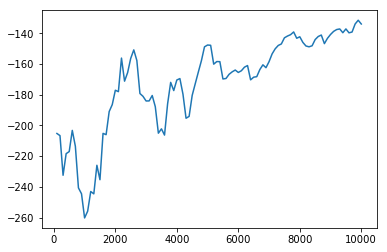

In [25]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda x:x[0]))
plt.plot(iters, ewma(np.array(session_rewards),span=10))

In [27]:
from tqdm import trange

for i in trange(10000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 99/10000 [00:30<50:57,  3.24it/s][2017-11-04 22:44:30,908] Making new env: LunarLander-v2
[2017-11-04 22:44:30,936] Clearing 6 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-143.38933353745315
Episode finished after 1000 timesteps with reward=-138.43861163191923


[2017-11-04 22:44:43,958] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  1%|          | 100/10000 [00:43<1:12:21,  2.28it/s]

Episode finished after 1000 timesteps with reward=-176.80691272795826
iter=10100	epsilon=0.050
Current score(mean over 3) = -152.878


  2%|▏         | 199/10000 [01:13<59:59,  2.72it/s]  [2017-11-04 22:45:13,523] Making new env: LunarLander-v2
[2017-11-04 22:45:13,550] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-122.54527794899725
Episode finished after 1000 timesteps with reward=-110.35189020002616


[2017-11-04 22:45:30,717] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  2%|▏         | 200/10000 [01:30<1:13:59,  2.21it/s]

Episode finished after 1000 timesteps with reward=-120.70034354861777
iter=10200	epsilon=0.050
Current score(mean over 3) = -117.866


  3%|▎         | 299/10000 [02:03<1:06:41,  2.42it/s][2017-11-04 22:46:03,630] Making new env: LunarLander-v2
[2017-11-04 22:46:03,655] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-143.4870926691052
Episode finished after 1000 timesteps with reward=-137.44431582705542


[2017-11-04 22:46:22,610] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  3%|▎         | 300/10000 [02:22<1:16:47,  2.11it/s]

Episode finished after 1000 timesteps with reward=-157.00400590786316
iter=10300	epsilon=0.050
Current score(mean over 3) = -145.978


  4%|▍         | 399/10000 [02:59<1:12:04,  2.22it/s][2017-11-04 22:47:00,711] Making new env: LunarLander-v2
[2017-11-04 22:47:00,727] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-135.96082726926332
Episode finished after 1000 timesteps with reward=-134.49837551388427


[2017-11-04 22:47:13,405] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  4%|▍         | 400/10000 [03:13<1:17:19,  2.07it/s]

Episode finished after 1000 timesteps with reward=-119.8742637854795
iter=10400	epsilon=0.050
Current score(mean over 3) = -130.111


  5%|▍         | 499/10000 [03:48<1:12:28,  2.18it/s][2017-11-04 22:47:48,703] Making new env: LunarLander-v2
[2017-11-04 22:47:48,737] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-168.9414268503587
Episode finished after 1000 timesteps with reward=-128.8572971388957


[2017-11-04 22:48:02,270] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  5%|▌         | 500/10000 [04:02<1:16:41,  2.06it/s]

Episode finished after 1000 timesteps with reward=-174.7741169204189
iter=10500	epsilon=0.050
Current score(mean over 3) = -157.524


  6%|▌         | 599/10000 [04:34<1:11:46,  2.18it/s][2017-11-04 22:48:34,969] Making new env: LunarLander-v2
[2017-11-04 22:48:34,989] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-158.59755244329054
Episode finished after 1000 timesteps with reward=-133.35252136294193


[2017-11-04 22:48:48,564] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  6%|▌         | 600/10000 [04:48<1:15:19,  2.08it/s]

Episode finished after 1000 timesteps with reward=-142.01482241268218
iter=10600	epsilon=0.050
Current score(mean over 3) = -144.655


  7%|▋         | 699/10000 [05:15<1:09:59,  2.21it/s][2017-11-04 22:49:15,896] Making new env: LunarLander-v2
[2017-11-04 22:49:15,904] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-131.3765337861477
Episode finished after 1000 timesteps with reward=-177.8009969057576


[2017-11-04 22:49:32,706] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  7%|▋         | 700/10000 [05:32<1:13:38,  2.10it/s]

Episode finished after 1000 timesteps with reward=-151.3847123909276
iter=10700	epsilon=0.050
Current score(mean over 3) = -153.521


  8%|▊         | 799/10000 [05:57<1:08:38,  2.23it/s][2017-11-04 22:49:58,153] Making new env: LunarLander-v2
[2017-11-04 22:49:58,159] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.29576522592174
Episode finished after 1000 timesteps with reward=-134.04122487880366


[2017-11-04 22:50:13,573] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  8%|▊         | 800/10000 [06:13<1:11:34,  2.14it/s]

Episode finished after 1000 timesteps with reward=-145.8601981492924
iter=10800	epsilon=0.050
Current score(mean over 3) = -137.399


  9%|▉         | 899/10000 [06:37<1:07:08,  2.26it/s][2017-11-04 22:50:38,301] Making new env: LunarLander-v2
[2017-11-04 22:50:38,332] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-130.76538608018137
Episode finished after 1000 timesteps with reward=-159.97671864025617


[2017-11-04 22:50:53,070] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
  9%|▉         | 900/10000 [06:52<1:09:35,  2.18it/s]

Episode finished after 1000 timesteps with reward=-162.63683024361808
iter=10900	epsilon=0.050
Current score(mean over 3) = -151.126


 10%|▉         | 999/10000 [07:16<1:05:33,  2.29it/s][2017-11-04 22:51:16,946] Making new env: LunarLander-v2
[2017-11-04 22:51:16,951] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-126.46285551855541
Episode finished after 1000 timesteps with reward=-163.58956110463976


[2017-11-04 22:51:26,833] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 10%|█         | 1000/10000 [07:26<1:07:00,  2.24it/s]

Episode finished after 1000 timesteps with reward=-142.27458985478654
iter=11000	epsilon=0.050
Current score(mean over 3) = -144.109


 11%|█         | 1099/10000 [07:53<1:03:50,  2.32it/s][2017-11-04 22:51:53,306] Making new env: LunarLander-v2
[2017-11-04 22:51:53,314] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-120.21620507312637
Episode finished after 1000 timesteps with reward=-171.34767382909425


[2017-11-04 22:52:07,425] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 11%|█         | 1101/10000 [08:07<1:05:40,  2.26it/s]

Episode finished after 1000 timesteps with reward=-181.0773927651
iter=11100	epsilon=0.050
Current score(mean over 3) = -157.547


 12%|█▏        | 1199/10000 [08:40<1:03:41,  2.30it/s][2017-11-04 22:52:41,390] Making new env: LunarLander-v2
[2017-11-04 22:52:41,398] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-108.1130135860529
Episode finished after 1000 timesteps with reward=-107.32278218234553


[2017-11-04 22:52:52,941] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 12%|█▏        | 1200/10000 [08:52<1:05:07,  2.25it/s]

Episode finished after 1000 timesteps with reward=-126.86700853262397
iter=11200	epsilon=0.050
Current score(mean over 3) = -114.101


 13%|█▎        | 1299/10000 [09:24<1:03:01,  2.30it/s][2017-11-04 22:53:24,874] Making new env: LunarLander-v2
[2017-11-04 22:53:24,896] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-170.7875185789915
Episode finished after 1000 timesteps with reward=-148.39127873165293


[2017-11-04 22:53:36,258] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 13%|█▎        | 1300/10000 [09:36<1:04:15,  2.26it/s]

Episode finished after 1000 timesteps with reward=-137.21769855241976
iter=11300	epsilon=0.050
Current score(mean over 3) = -152.132


 14%|█▍        | 1399/10000 [10:06<1:02:07,  2.31it/s][2017-11-04 22:54:06,751] Making new env: LunarLander-v2
[2017-11-04 22:54:06,773] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-103.31625019359883
Episode finished after 1000 timesteps with reward=-133.5181572581226


[2017-11-04 22:54:21,489] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 14%|█▍        | 1400/10000 [10:21<1:03:37,  2.25it/s]

Episode finished after 1000 timesteps with reward=-152.59660429119802
iter=11400	epsilon=0.050
Current score(mean over 3) = -129.810


 15%|█▍        | 1499/10000 [10:57<1:02:10,  2.28it/s][2017-11-04 22:54:58,167] Making new env: LunarLander-v2
[2017-11-04 22:54:58,189] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-149.78275733249356
Episode finished after 1000 timesteps with reward=-114.19776538464573


[2017-11-04 22:55:10,868] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 15%|█▌        | 1501/10000 [11:10<1:03:18,  2.24it/s]

Episode finished after 1000 timesteps with reward=-159.0108704748387
iter=11500	epsilon=0.050
Current score(mean over 3) = -140.997


 16%|█▌        | 1599/10000 [11:39<1:01:14,  2.29it/s][2017-11-04 22:55:39,795] Making new env: LunarLander-v2
[2017-11-04 22:55:39,802] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-165.05863180292698
Episode finished after 1000 timesteps with reward=-128.69998256942728


[2017-11-04 22:55:55,089] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 16%|█▌        | 1600/10000 [11:54<1:02:33,  2.24it/s]

Episode finished after 1000 timesteps with reward=-164.29428434621946
iter=11600	epsilon=0.050
Current score(mean over 3) = -152.684


 17%|█▋        | 1699/10000 [12:20<1:00:18,  2.29it/s][2017-11-04 22:56:20,945] Making new env: LunarLander-v2
[2017-11-04 22:56:20,972] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-148.57380136747722
Episode finished after 1000 timesteps with reward=-129.08906247509955


[2017-11-04 22:56:32,349] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 17%|█▋        | 1700/10000 [12:32<1:01:12,  2.26it/s]

Episode finished after 1000 timesteps with reward=-114.1758207783207
iter=11700	epsilon=0.050
Current score(mean over 3) = -130.613


 18%|█▊        | 1799/10000 [12:58<59:10,  2.31it/s][2017-11-04 22:56:59,328] Making new env: LunarLander-v2
[2017-11-04 22:56:59,348] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-175.08774700464852
Episode finished after 1000 timesteps with reward=-189.74314788448496


[2017-11-04 22:57:13,301] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 18%|█▊        | 1800/10000 [13:13<1:00:13,  2.27it/s]

Episode finished after 1000 timesteps with reward=-154.32411645223635
iter=11800	epsilon=0.050
Current score(mean over 3) = -173.052


 19%|█▉        | 1899/10000 [13:39<58:16,  2.32it/s][2017-11-04 22:57:39,884] Making new env: LunarLander-v2
[2017-11-04 22:57:39,909] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-160.25589044017784
Episode finished after 1000 timesteps with reward=-147.56004731532278


[2017-11-04 22:57:55,623] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 19%|█▉        | 1900/10000 [13:55<59:21,  2.27it/s]

Episode finished after 1000 timesteps with reward=-146.98072139219386
iter=11900	epsilon=0.050
Current score(mean over 3) = -151.599


 20%|█▉        | 1999/10000 [14:23<57:34,  2.32it/s][2017-11-04 22:58:23,588] Making new env: LunarLander-v2
[2017-11-04 22:58:23,613] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-154.99252799813993
Episode finished after 1000 timesteps with reward=-158.97636470669218


[2017-11-04 22:58:35,420] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 20%|██        | 2000/10000 [14:35<58:21,  2.28it/s]

Episode finished after 1000 timesteps with reward=-126.07137100275635
iter=12000	epsilon=0.050
Current score(mean over 3) = -146.680


 21%|██        | 2099/10000 [15:05<56:47,  2.32it/s][2017-11-04 22:59:05,571] Making new env: LunarLander-v2
[2017-11-04 22:59:05,608] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-158.77616328261936
Episode finished after 1000 timesteps with reward=-180.17410846907106


[2017-11-04 22:59:18,899] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 21%|██        | 2100/10000 [15:18<57:36,  2.29it/s]

Episode finished after 1000 timesteps with reward=-187.9299066398737
iter=12100	epsilon=0.050
Current score(mean over 3) = -175.627


 22%|██▏       | 2199/10000 [15:45<55:53,  2.33it/s][2017-11-04 22:59:45,870] Making new env: LunarLander-v2
[2017-11-04 22:59:45,878] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-109.20959952557311
Episode finished after 1000 timesteps with reward=-121.4488528932732


[2017-11-04 22:59:58,240] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 22%|██▏       | 2200/10000 [15:58<56:37,  2.30it/s]

Episode finished after 1000 timesteps with reward=-139.9675221477822
iter=12200	epsilon=0.050
Current score(mean over 3) = -123.542


 23%|██▎       | 2299/10000 [16:31<55:22,  2.32it/s][2017-11-04 23:00:32,322] Making new env: LunarLander-v2
[2017-11-04 23:00:32,348] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-155.96453631837397
Episode finished after 1000 timesteps with reward=-97.08764090087375


[2017-11-04 23:00:42,479] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 23%|██▎       | 2301/10000 [16:42<55:54,  2.30it/s]

Episode finished after 1000 timesteps with reward=-147.01768992521474
iter=12300	epsilon=0.050
Current score(mean over 3) = -133.357


 24%|██▍       | 2399/10000 [17:08<54:19,  2.33it/s][2017-11-04 23:01:09,227] Making new env: LunarLander-v2
[2017-11-04 23:01:09,235] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-112.09806684774982
Episode finished after 1000 timesteps with reward=-157.42308671634922


[2017-11-04 23:01:23,574] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 24%|██▍       | 2400/10000 [17:23<55:04,  2.30it/s]

Episode finished after 1000 timesteps with reward=-160.7109469629108
iter=12400	epsilon=0.050
Current score(mean over 3) = -143.411


 25%|██▍       | 2499/10000 [17:51<53:35,  2.33it/s][2017-11-04 23:01:51,940] Making new env: LunarLander-v2
[2017-11-04 23:01:51,970] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 142 timesteps with reward=-123.41464373162978
Episode finished after 1000 timesteps with reward=-167.4300554102939


[2017-11-04 23:01:59,501] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 25%|██▌       | 2501/10000 [17:59<53:56,  2.32it/s]

Episode finished after 1000 timesteps with reward=-142.32989343200407
iter=12500	epsilon=0.050
Current score(mean over 3) = -144.392


 26%|██▌       | 2599/10000 [18:26<52:31,  2.35it/s][2017-11-04 23:02:27,082] Making new env: LunarLander-v2
[2017-11-04 23:02:27,104] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-155.95254651564352
Episode finished after 1000 timesteps with reward=-138.91204357601924


[2017-11-04 23:02:41,186] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 26%|██▌       | 2600/10000 [18:41<53:10,  2.32it/s]

Episode finished after 1000 timesteps with reward=-162.68115740746308
iter=12600	epsilon=0.050
Current score(mean over 3) = -152.515


 27%|██▋       | 2699/10000 [19:15<52:04,  2.34it/s][2017-11-04 23:03:15,534] Making new env: LunarLander-v2
[2017-11-04 23:03:15,561] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-110.94304772562894
Episode finished after 1000 timesteps with reward=-125.67507567429473


[2017-11-04 23:03:32,249] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 27%|██▋       | 2700/10000 [19:32<52:49,  2.30it/s]

Episode finished after 1000 timesteps with reward=-172.731404716755
iter=12700	epsilon=0.050
Current score(mean over 3) = -136.450


 28%|██▊       | 2799/10000 [19:59<51:26,  2.33it/s][2017-11-04 23:03:59,935] Making new env: LunarLander-v2
[2017-11-04 23:03:59,945] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-175.95074158225157
Episode finished after 1000 timesteps with reward=-117.81373322618667


[2017-11-04 23:04:17,057] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 28%|██▊       | 2801/10000 [20:17<52:08,  2.30it/s]

Episode finished after 1000 timesteps with reward=-126.50898008636992
iter=12800	epsilon=0.050
Current score(mean over 3) = -140.091


 29%|██▉       | 2899/10000 [20:48<50:59,  2.32it/s][2017-11-04 23:04:49,407] Making new env: LunarLander-v2
[2017-11-04 23:04:49,418] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-166.44439165887263
Episode finished after 1000 timesteps with reward=-127.57930299302267


[2017-11-04 23:05:09,187] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 29%|██▉       | 2900/10000 [21:09<51:47,  2.29it/s]

Episode finished after 1000 timesteps with reward=-137.03827059246242
iter=12900	epsilon=0.050
Current score(mean over 3) = -143.687


 30%|██▉       | 2999/10000 [21:47<50:52,  2.29it/s][2017-11-04 23:05:48,077] Making new env: LunarLander-v2
[2017-11-04 23:05:48,087] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-102.66528566349997
Episode finished after 1000 timesteps with reward=-160.60209058737325


[2017-11-04 23:06:09,152] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 30%|███       | 3000/10000 [22:09<51:41,  2.26it/s]

Episode finished after 1000 timesteps with reward=-137.01185247422342
iter=13000	epsilon=0.050
Current score(mean over 3) = -133.426


 31%|███       | 3099/10000 [22:47<50:44,  2.27it/s][2017-11-04 23:06:47,646] Making new env: LunarLander-v2
[2017-11-04 23:06:47,673] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-151.6476734023472
Episode finished after 1000 timesteps with reward=-154.38546254582815


[2017-11-04 23:07:06,618] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 31%|███       | 3100/10000 [23:06<51:26,  2.24it/s]

Episode finished after 1000 timesteps with reward=-158.456697982927
iter=13100	epsilon=0.050
Current score(mean over 3) = -154.830


 32%|███▏      | 3199/10000 [23:39<50:16,  2.25it/s][2017-11-04 23:07:39,288] Making new env: LunarLander-v2
[2017-11-04 23:07:39,296] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-111.07203594518633
Episode finished after 94 timesteps with reward=-203.55678990401643


[2017-11-04 23:07:50,601] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 32%|███▏      | 3201/10000 [23:50<50:38,  2.24it/s]

Episode finished after 1000 timesteps with reward=-136.69997105287732
iter=13200	epsilon=0.050
Current score(mean over 3) = -150.443


 33%|███▎      | 3299/10000 [24:21<49:28,  2.26it/s][2017-11-04 23:08:21,692] Making new env: LunarLander-v2
[2017-11-04 23:08:21,713] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-105.22021215258621
Episode finished after 1000 timesteps with reward=-107.98598233427118


[2017-11-04 23:08:38,487] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 33%|███▎      | 3301/10000 [24:38<50:00,  2.23it/s]

Episode finished after 1000 timesteps with reward=-147.01176210633054
iter=13300	epsilon=0.050
Current score(mean over 3) = -120.073


 34%|███▍      | 3399/10000 [25:11<48:54,  2.25it/s][2017-11-04 23:09:11,405] Making new env: LunarLander-v2
[2017-11-04 23:09:11,415] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.25928773581208
Episode finished after 1000 timesteps with reward=-140.5723781310179


[2017-11-04 23:09:24,697] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 34%|███▍      | 3400/10000 [25:24<49:19,  2.23it/s]

Episode finished after 1000 timesteps with reward=-128.50016137553604
iter=13400	epsilon=0.050
Current score(mean over 3) = -133.777


 35%|███▍      | 3499/10000 [25:52<48:04,  2.25it/s][2017-11-04 23:09:53,273] Making new env: LunarLander-v2
[2017-11-04 23:09:53,298] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-159.59437745660088
Episode finished after 1000 timesteps with reward=-113.54075556233461


[2017-11-04 23:10:09,257] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 35%|███▌      | 3500/10000 [26:09<48:34,  2.23it/s]

Episode finished after 1000 timesteps with reward=-120.0637737358601
iter=13500	epsilon=0.050
Current score(mean over 3) = -131.066


 36%|███▌      | 3599/10000 [26:41<47:28,  2.25it/s][2017-11-04 23:10:41,765] Making new env: LunarLander-v2
[2017-11-04 23:10:41,784] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 148 timesteps with reward=-141.6966731613448
Episode finished after 1000 timesteps with reward=-132.49171193367096


[2017-11-04 23:10:51,553] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 36%|███▌      | 3601/10000 [26:51<47:43,  2.23it/s]

Episode finished after 1000 timesteps with reward=-130.52400298098144
iter=13600	epsilon=0.050
Current score(mean over 3) = -134.904


 37%|███▋      | 3699/10000 [27:18<46:31,  2.26it/s][2017-11-04 23:11:19,225] Making new env: LunarLander-v2
[2017-11-04 23:11:19,232] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-137.3130232996279
Episode finished after 1000 timesteps with reward=-131.63361536160892


[2017-11-04 23:11:32,391] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 37%|███▋      | 3700/10000 [27:32<46:53,  2.24it/s]

Episode finished after 1000 timesteps with reward=-134.0080955871241
iter=13700	epsilon=0.050
Current score(mean over 3) = -134.318


 38%|███▊      | 3799/10000 [28:00<45:43,  2.26it/s][2017-11-04 23:12:01,062] Making new env: LunarLander-v2
[2017-11-04 23:12:01,085] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-132.54219423421873
Episode finished after 1000 timesteps with reward=-151.05652784706015


[2017-11-04 23:12:13,807] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 38%|███▊      | 3800/10000 [28:13<46:03,  2.24it/s]

Episode finished after 1000 timesteps with reward=-183.908779550537
iter=13800	epsilon=0.050
Current score(mean over 3) = -155.836


 39%|███▉      | 3899/10000 [28:38<44:49,  2.27it/s][2017-11-04 23:12:39,240] Making new env: LunarLander-v2
[2017-11-04 23:12:39,248] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-153.23723847328384
Episode finished after 1000 timesteps with reward=-145.68321603163133


[2017-11-04 23:12:53,265] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 39%|███▉      | 3900/10000 [28:53<45:10,  2.25it/s]

Episode finished after 1000 timesteps with reward=-164.58504355954813
iter=13900	epsilon=0.050
Current score(mean over 3) = -154.502


 40%|███▉      | 3999/10000 [29:23<44:06,  2.27it/s][2017-11-04 23:13:24,161] Making new env: LunarLander-v2
[2017-11-04 23:13:24,181] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-161.50489643510767
Episode finished after 126 timesteps with reward=-170.9988837063923


[2017-11-04 23:13:37,442] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 40%|████      | 4001/10000 [29:37<44:25,  2.25it/s]

Episode finished after 1000 timesteps with reward=-144.19881254906613
iter=14000	epsilon=0.050
Current score(mean over 3) = -158.901


 41%|████      | 4099/10000 [30:06<43:20,  2.27it/s][2017-11-04 23:14:07,070] Making new env: LunarLander-v2
[2017-11-04 23:14:07,091] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-110.45803006684409
Episode finished after 1000 timesteps with reward=-131.5872783292744


[2017-11-04 23:14:25,408] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 41%|████      | 4100/10000 [30:25<43:46,  2.25it/s]

Episode finished after 1000 timesteps with reward=-124.60914497327026
iter=14100	epsilon=0.050
Current score(mean over 3) = -122.218


 42%|████▏     | 4199/10000 [30:53<42:40,  2.27it/s][2017-11-04 23:14:53,951] Making new env: LunarLander-v2
[2017-11-04 23:14:53,973] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-151.8585737610222
Episode finished after 1000 timesteps with reward=-97.81262675363234


[2017-11-04 23:15:05,780] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 42%|████▏     | 4200/10000 [31:05<42:56,  2.25it/s]

Episode finished after 1000 timesteps with reward=-202.7144470074639
iter=14200	epsilon=0.050
Current score(mean over 3) = -150.795


 43%|████▎     | 4299/10000 [31:35<41:53,  2.27it/s][2017-11-04 23:15:35,799] Making new env: LunarLander-v2
[2017-11-04 23:15:35,806] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 133 timesteps with reward=-145.8279109973744
Episode finished after 1000 timesteps with reward=-146.90383535826743


[2017-11-04 23:15:45,561] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 43%|████▎     | 4300/10000 [31:45<42:05,  2.26it/s]

Episode finished after 1000 timesteps with reward=-135.32683616775773
iter=14300	epsilon=0.050
Current score(mean over 3) = -142.686


 44%|████▍     | 4399/10000 [32:12<41:00,  2.28it/s][2017-11-04 23:16:12,472] Making new env: LunarLander-v2
[2017-11-04 23:16:12,480] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-151.87229705604446
Episode finished after 1000 timesteps with reward=-153.26270003754206


[2017-11-04 23:16:27,112] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 44%|████▍     | 4400/10000 [32:27<41:18,  2.26it/s]

Episode finished after 1000 timesteps with reward=-144.40156365438153
iter=14400	epsilon=0.050
Current score(mean over 3) = -149.846


 45%|████▍     | 4499/10000 [32:55<40:15,  2.28it/s][2017-11-04 23:16:55,628] Making new env: LunarLander-v2
[2017-11-04 23:16:55,634] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-103.96832785705523
Episode finished after 1000 timesteps with reward=-178.6222614867868


[2017-11-04 23:17:07,203] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 45%|████▌     | 4500/10000 [33:07<40:28,  2.26it/s]

Episode finished after 1000 timesteps with reward=-135.22216010766078
iter=14500	epsilon=0.050
Current score(mean over 3) = -139.271


 46%|████▌     | 4599/10000 [33:33<39:24,  2.28it/s][2017-11-04 23:17:34,024] Making new env: LunarLander-v2
[2017-11-04 23:17:34,045] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-178.1187786116958
Episode finished after 1000 timesteps with reward=-190.34568485041487


[2017-11-04 23:17:47,449] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 46%|████▌     | 4600/10000 [33:47<39:39,  2.27it/s]

Episode finished after 1000 timesteps with reward=-167.12092074069514
iter=14600	epsilon=0.050
Current score(mean over 3) = -178.528


 47%|████▋     | 4699/10000 [34:14<38:37,  2.29it/s][2017-11-04 23:18:14,558] Making new env: LunarLander-v2
[2017-11-04 23:18:14,588] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-157.79684292297944
Episode finished after 1000 timesteps with reward=-185.04146392470375


[2017-11-04 23:18:30,644] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 47%|████▋     | 4701/10000 [34:30<38:54,  2.27it/s]

Episode finished after 1000 timesteps with reward=-164.51109365946743
iter=14700	epsilon=0.050
Current score(mean over 3) = -169.116


 48%|████▊     | 4799/10000 [34:56<37:52,  2.29it/s][2017-11-04 23:18:57,039] Making new env: LunarLander-v2
[2017-11-04 23:18:57,061] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-170.61360344251844
Episode finished after 1000 timesteps with reward=-138.22242217163154


[2017-11-04 23:19:08,513] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 48%|████▊     | 4800/10000 [35:08<38:04,  2.28it/s]

Episode finished after 1000 timesteps with reward=-170.02929373524591
iter=14800	epsilon=0.050
Current score(mean over 3) = -159.622


 49%|████▉     | 4899/10000 [35:40<37:08,  2.29it/s][2017-11-04 23:19:41,222] Making new env: LunarLander-v2
[2017-11-04 23:19:41,244] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-153.78992379243059
Episode finished after 1000 timesteps with reward=-102.91533632582596


[2017-11-04 23:19:53,977] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 49%|████▉     | 4900/10000 [35:53<37:21,  2.27it/s]

Episode finished after 1000 timesteps with reward=-163.2891164864576
iter=14900	epsilon=0.050
Current score(mean over 3) = -139.998


 50%|████▉     | 4999/10000 [36:24<36:25,  2.29it/s][2017-11-04 23:20:24,773] Making new env: LunarLander-v2
[2017-11-04 23:20:24,793] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 186 timesteps with reward=-134.34286990021664
Episode finished after 1000 timesteps with reward=-131.089445553462


[2017-11-04 23:20:33,425] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 50%|█████     | 5000/10000 [36:33<36:33,  2.28it/s]

Episode finished after 1000 timesteps with reward=-190.66893384726134
iter=15000	epsilon=0.050
Current score(mean over 3) = -152.034


 51%|█████     | 5099/10000 [37:01<35:35,  2.30it/s][2017-11-04 23:21:02,214] Making new env: LunarLander-v2
[2017-11-04 23:21:02,237] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-159.66641455242114
Episode finished after 1000 timesteps with reward=-162.93202398795225


[2017-11-04 23:21:15,966] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 51%|█████     | 5100/10000 [37:15<35:48,  2.28it/s]

Episode finished after 1000 timesteps with reward=-147.65482475438543
iter=15100	epsilon=0.050
Current score(mean over 3) = -156.751


 52%|█████▏    | 5199/10000 [37:46<34:53,  2.29it/s][2017-11-04 23:21:47,304] Making new env: LunarLander-v2
[2017-11-04 23:21:47,311] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-109.81063689187934
Episode finished after 1000 timesteps with reward=-140.4900134069601


[2017-11-04 23:22:03,885] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 52%|█████▏    | 5200/10000 [38:03<35:08,  2.28it/s]

Episode finished after 1000 timesteps with reward=-195.11112938660574
iter=15200	epsilon=0.050
Current score(mean over 3) = -148.471


 53%|█████▎    | 5299/10000 [38:32<34:11,  2.29it/s][2017-11-04 23:22:33,183] Making new env: LunarLander-v2
[2017-11-04 23:22:33,190] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-154.15372578681882
Episode finished after 1000 timesteps with reward=-160.69191917744973


[2017-11-04 23:22:45,175] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 53%|█████▎    | 5300/10000 [38:45<34:21,  2.28it/s]

Episode finished after 1000 timesteps with reward=-162.7080475679551
iter=15300	epsilon=0.050
Current score(mean over 3) = -159.185


 54%|█████▍    | 5399/10000 [39:15<33:26,  2.29it/s][2017-11-04 23:23:15,491] Making new env: LunarLander-v2
[2017-11-04 23:23:15,510] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-158.84656160476894
Episode finished after 1000 timesteps with reward=-111.30752930679938


[2017-11-04 23:23:24,942] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 54%|█████▍    | 5400/10000 [39:24<33:34,  2.28it/s]

Episode finished after 139 timesteps with reward=-147.38212954290617
iter=15400	epsilon=0.050
Current score(mean over 3) = -139.179


 55%|█████▍    | 5499/10000 [39:53<32:39,  2.30it/s][2017-11-04 23:23:53,915] Making new env: LunarLander-v2
[2017-11-04 23:23:53,923] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 205 timesteps with reward=-171.63555313132272
Episode finished after 1000 timesteps with reward=-180.35728302416345


[2017-11-04 23:24:04,871] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 55%|█████▌    | 5500/10000 [40:04<32:47,  2.29it/s]

Episode finished after 1000 timesteps with reward=-86.68913736965493
iter=15500	epsilon=0.050
Current score(mean over 3) = -146.227


 56%|█████▌    | 5599/10000 [40:38<31:57,  2.30it/s][2017-11-04 23:24:39,245] Making new env: LunarLander-v2
[2017-11-04 23:24:39,253] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-165.71438314152024
Episode finished after 224 timesteps with reward=-152.29770835964595


[2017-11-04 23:24:47,781] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 56%|█████▌    | 5600/10000 [40:47<32:03,  2.29it/s]

Episode finished after 1000 timesteps with reward=-147.48794045151936
iter=15600	epsilon=0.050
Current score(mean over 3) = -155.167


 57%|█████▋    | 5699/10000 [41:18<31:10,  2.30it/s][2017-11-04 23:25:18,900] Making new env: LunarLander-v2
[2017-11-04 23:25:18,921] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-92.49755007402679
Episode finished after 1000 timesteps with reward=-139.1104767596936


[2017-11-04 23:25:32,622] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 57%|█████▋    | 5700/10000 [41:32<31:20,  2.29it/s]

Episode finished after 1000 timesteps with reward=-136.7302655924316
iter=15700	epsilon=0.050
Current score(mean over 3) = -122.779


 58%|█████▊    | 5799/10000 [42:03<30:27,  2.30it/s][2017-11-04 23:26:03,454] Making new env: LunarLander-v2
[2017-11-04 23:26:03,475] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-134.6405081690015
Episode finished after 1000 timesteps with reward=-157.16781752705154


[2017-11-04 23:26:13,974] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 58%|█████▊    | 5800/10000 [42:13<30:34,  2.29it/s]

Episode finished after 1000 timesteps with reward=-143.91438342893662
iter=15800	epsilon=0.050
Current score(mean over 3) = -145.241


 59%|█████▉    | 5899/10000 [42:40<29:39,  2.30it/s][2017-11-04 23:26:40,485] Making new env: LunarLander-v2
[2017-11-04 23:26:40,513] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-146.76662547686442
Episode finished after 1000 timesteps with reward=-125.75684606637492


[2017-11-04 23:26:57,329] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/nimloth/coding/7sem/machine_learning_7sem/hw5/records')
 59%|█████▉    | 5900/10000 [42:57<29:50,  2.29it/s]

Episode finished after 1000 timesteps with reward=-166.51547548143066
iter=15900	epsilon=0.050
Current score(mean over 3) = -146.346


 60%|█████▉    | 5999/10000 [43:27<28:59,  2.30it/s][2017-11-04 23:27:28,083] Making new env: LunarLander-v2
[2017-11-04 23:27:28,093] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 1000 timesteps with reward=-144.2501556674284
Episode finished after 1000 timesteps with reward=-170.40772624635042


KeyboardInterrupt: 

Я остановила, так как кажется, улучшений особо не предвидится. Летающая штука научилась летать и не хочет приземляться. Возможно, можно попробовать улучшить скор, запустив еще несколько раз (рандом!), или же увеличить рандом путем выбора эпсилона.

In [28]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-11-04 23:27:45,373] Making new env: LunarLander-v2
[2017-11-04 23:27:45,408] Starting new video recorder writing to /home/nimloth/coding/7sem/machine_learning_7sem/hw5/records/openaigym.video.162.3688.video000000.mp4



Episode finished after 1000 timesteps with reward=-148.41183050625034


[2017-11-04 23:28:25,679] Starting new video recorder writing to /home/nimloth/coding/7sem/machine_learning_7sem/hw5/records/openaigym.video.162.3688.video000001.mp4



Episode finished after 1000 timesteps with reward=-176.4369182180606
Episode finished after 1000 timesteps with reward=-138.0528507485633
Episode finished after 1000 timesteps with reward=-133.34883995351146
Episode finished after 1000 timesteps with reward=-165.40362593032333
Episode finished after 1000 timesteps with reward=-139.6239676097969
Episode finished after 1000 timesteps with reward=-151.79117423155697


[2017-11-04 23:29:42,784] Starting new video recorder writing to /home/nimloth/coding/7sem/machine_learning_7sem/hw5/records/openaigym.video.162.3688.video000008.mp4



Episode finished after 1000 timesteps with reward=-91.9883170035754


ArgumentError: argument 2: <class 'TypeError'>: wrong type